# Activity models

In [1]:
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot

PyPlot

In this notebook, we will be giving examples on how to use activity models within `Clapeyron.jl`. We include examples of how one can customise their activity model and how it can be used in tangent with a cubic equation of state.

## $p-xy$ diagram of water+ethanol

Activity models cannot be used on their own; they provide us with an activity for a species in the mixture but, to obtain VLE properties from this, we need a saturation pressure. This can be obtained from any of the equations of state provided in `Clapeyron.jl` using the optional argument `puremodel`. We use the water + ethanol mixture as an example:

In [2]:
model1 = Wilson(["water","ethanol"];puremodel=SRK)
model2 = NRTL(["water","ethanol"];puremodel=PR)
model3 = UNIFAC(["water","ethanol"];puremodel=PCSAFT)
model4 = COSMOSACdsp(["water","ethanol"];puremodel=SAFTgammaMie)

models = [model1,model2,model3,model4];

We can then obtain the VLE envelope directly using the `bubble_pressure` function:

In [3]:
T = 423.15
x = range(1e-5,1-1e-5,length=200)
X = Clapeyron.FractionVector.(x)

y = []
p = []
for i ∈ 1:4
    v0 =[]
    bub = bubble_pressure.(models[i],T,X)
    append!(y,[append!([bub[i][2][1] for i ∈ 1:200],reverse(x))])
    append!(p,[append!([bub[i][1] for i ∈ 1:200],[bub[i][1] for i ∈ 200:-1:1])])
end

Plotting:

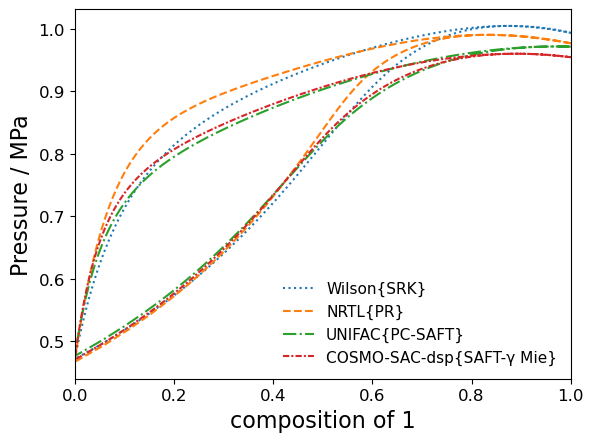

In [10]:
plt.clf()
plt.plot(1 .-y[1],p[1]./1e6,label="Wilson{SRK}",linestyle=":")
plt.plot(1 .-y[2],p[2]./1e6,label="NRTL{PR}",linestyle="--")
plt.plot(1 .-y[3],p[3]./1e6,label="UNIFAC{PC-SAFT}",linestyle="-.")
plt.plot(1 .-y[4],p[4]./1e6,label="COSMO-SAC-dsp{SAFT-γ Mie}",linestyle=(0, (3, 1, 1, 1)))
plt.legend(frameon=false,fontsize=11) 
plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,1])
display(plt.gcf())

## $T-xy$ diagram of water + ethanol

Activity models can be used in tangent with cubic equations of state within mixing rules. This can greatly improve the accuracy of either model when used in isolation. We again use the water + ethanol system as an example.

We define the activity based models the same way as before; to use an activity model within a cubic equation of state, we must specify the optional arguments `mixing` for the mixing rule and `activity` for the particular activity model we're using:

In [11]:
model1 = Wilson(["water","ethanol"];puremodel=PR)
model2 = NRTL(["water","ethanol"];puremodel=PR)
model3 = UNIQUAC(["water","ethanol"];puremodel=PR)
model4 = PR(["water","ethanol"];mixing=HVRule,activity=Wilson)
model5 = PR(["water","ethanol"];mixing=WSRule,activity=NRTL)
model6 = PR(["water","ethanol"];mixing=LCVMRule,activity=UNIQUAC)

models = [model1,model2,model3,model4,model5,model6];

We can then obtain the VLE envelope directly using the `bubble_temperature` function:

In [12]:
x = range(1e-5,1-1e-5,length=100)
X = Clapeyron.FractionVector.(x)
T = []
y = []

for j=1:6
    A = []
    B = []
    T0 = 351
    for i=1:100
        bub = bubble_temperature(models[j],1.0133e5,X[i];T0=T0)
        append!(A,bub[1])
        if j<=3
            append!(B,bub[2][1])
        else
            append!(B,bub[4][1])
        end
        T0 = deepcopy(A[i])
    end
    append!(A,reverse(A))
    append!(T,[A])
    append!(B,reverse(x))
    append!(y,[B])
end

The above is an example of how one can generate these figures quickly (and smoothly). We can re-use the solution from the previous iteration as an initial guess to the next iteration.

Plotting:

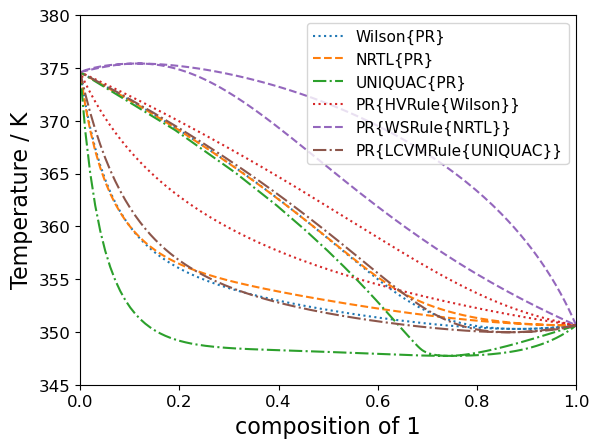

In [15]:
plt.clf()
plt.plot(1 .-y[1],T[1],label="Wilson{PR}",linestyle=":")
plt.plot(1 .-y[2],T[2],label="NRTL{PR}",linestyle="--")
plt.plot(1 .-y[3],T[3],label="UNIQUAC{PR}",linestyle="-.")
plt.plot(1 .-y[4],T[4],label="PR{HVRule{Wilson}}",linestyle=":")
plt.plot(1 .-y[5],T[5],label="PR{WSRule{NRTL}}",linestyle="--")
plt.plot(1 .-y[6],T[6],label="PR{LCVMRule{UNIQUAC}}",linestyle="-.")
plt.legend(loc="upper right",frameon=false,fontsize=11) 
plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,1])
plt.ylim([345,380])
display(plt.gcf())

As we can see above, in most cases, the activity model out-performs the implementation within a mixing rule. However, interestingly enough, if the activity model performs quite poorly alone, implementing it within a mixing rule can greatly improve the predictions, as is the case with UNIQUAC.